TODO

add description

In [1]:
import pandas as pd
from datetime import datetime

Time series regression models is a statistical method for predicting a future response based on response history.

For this example, we are going to use ```Beijing PM2.5 Dataset```. The dataset contains hourly data of the PM2.5 from US Embassy in Beijing. PM2.5 is a common measurement used to measures air quality.

The objective is we are going forecast the PM2.5 value for the upcoming next week.
	
more about the dataset: https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data#

In [2]:
air = pd.read_csv('../datasets/regression/PRSA_data_2010.1.1-2014.12.31.csv')
air.index = pd.to_datetime(air[['year', 'month', 'day', 'hour']])
air.head(5)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
2010-01-01 00:00:00,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


table above shows the summary of beijing air pollution dataset. ```pm2.5``` is the value of interest $y$, and ```dewp, temp, pres, cbwd, lwd, ls, lr``` are the predictors $x$.

## Descriptive Analysis

Before we start, lets quickly check the distribution, missing values, and unique values of our dataset

In [3]:
#remove unused column
air = air.drop("No", axis=1)

In [4]:
air.describe()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [5]:
def get_missing_value_and_unique_count(dataframe):
    missing_value_count = dataframe.isna().sum()
    unique_count = dataframe.apply(lambda x: len(x.unique()))
    
    return pd.DataFrame({'missing_value': missing_value_count,'unique': unique_count})

In [6]:
# check missing values and unique count
get_missing_value_and_unique_count(air)

,missing_value,unique
year,0,5
month,0,12
day,0,31
hour,0,24
pm2.5,2067,582
DEWP,0,69
TEMP,0,64
PRES,0,60
cbwd,0,4
Iws,0,2788


In [7]:
air.apply(set)

year                        {2010, 2011, 2012, 2013, 2014}
month              {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
day      {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
hour     {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
pm2.5    {nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
DEWP     {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
TEMP     {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...
PRES     {1024.0, 1025.0, 1026.0, 1027.0, 1028.0, 1029....
cbwd                                      {cv, NE, SE, NW}
Iws      {2.25, 4.91, 4.02, 6.25, 7.16, 8.93, 9.84, 8.5...
Is       {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
Ir       {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
dtype: object

In [8]:
import matplotlib.pyplot as plt
plt.rc('figure',figsize=(16,6))

air_2010 = air[air['year']==2010]

plt.plot(air_2010['pm2.5'])
plt.title("pm2.5 in year 2010")

plt.show()

C:\Users\willi\AppData\Local\Continuum\miniconda3\envs\main\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<Figure size 1600x600 with 1 Axes>

## Impute Missing Values

Since there are missing values in ```pm2.5```, we can fill it with some value.

There are several ways to do a value imputation.

***Non-time-series specific method***

- Mean imputation
- Median imputation
- Mode imputation 
- Random sample imputation (replace missing values with observations randomly selected from the remaining (either of it or just some section of it)

*These method can be use if series has no trend and seasonality*

***Time-Series specific method***

- Last observation carried forward (LOCF)
- Next observation carried backward (NOCB)
- Linear interpolation or Spline interpolation

*Interpolation methods rely on the assumption that adjacent observations are similar to one another,  do not work well when this assumption is not valid, especially when the presence of strong seasonality*

Lets impute the missing value using LOCF

In [9]:
# imputation using LOCF
air['pm2.5'] = air['pm2.5'].fillna(method='ffill')
air['pm2.5'] = air['pm2.5'].fillna(method='bfill')

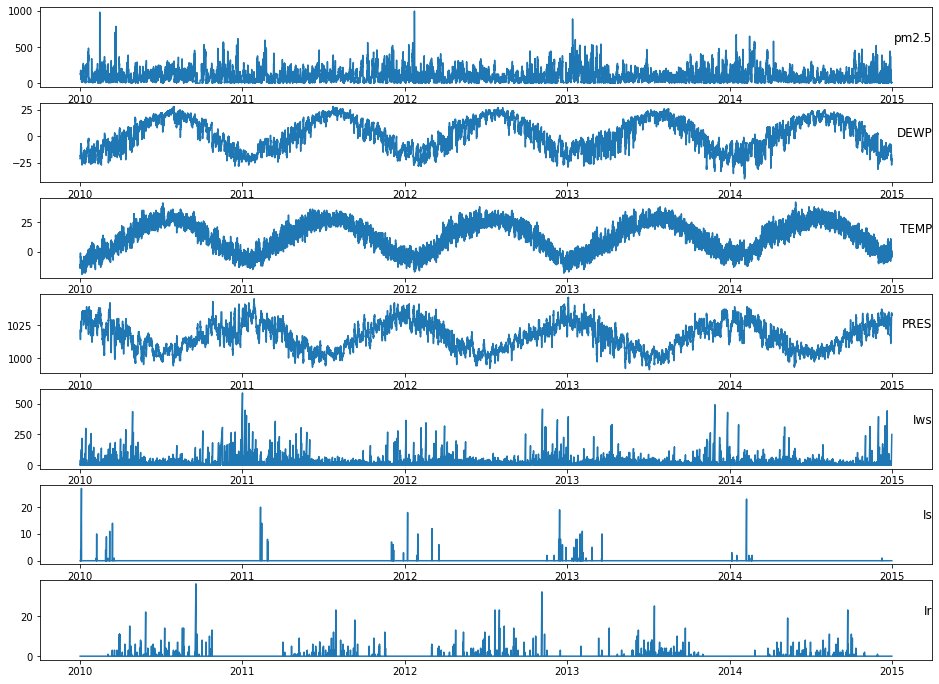

In [10]:
# specify columns to plot
groups = ['pm2.5','DEWP','TEMP','PRES','Iws','Is','Ir']
i = 1
# plot each column
plt.figure(figsize=(16,12))
for group in groups:
    series = air[group]
    plt.subplot(len(groups), 1, i)
    plt.plot(series)
    plt.title(series.name, y=0.5, loc='right')
    i += 1
    
plt.show()

In [11]:
# plt.rc('figure',figsize=(6, 4))

# plt.hist(air['cbwd'])
# plt.show()

## One Hot Encode Categorical Variable

The categorical variables we have here are ```cbwd, year, month, day, hour```. We will be using one hot encoding to represent the categorical variables into binary vectors. 

For example, categories in ```cbwd``` are ```NW, cv, NE, SE``` will be convert into binary vectors as below:

| NE | NW | SE | cv |
|---|---|---|---|
| 1 | 0 | 0 | 0 |
| 0 | 1 | 0 | 0 |
| 0 | 0 | 1 | 0 |
| 0 | 0 | 0 | 1 |

However to avoid **Dummy variable trap** which is the common problem in regression model, we have to remove any one of the encoded column. Hence the number of dummy variables necessary to represent a single attribute variable is equal to the number of categories in the variable minus one.

| NW | SE | cv |
|---|---|---|
| 1 | 0 | 0 |
| 0 | 1 | 0 |
| 0 | 0 | 1 |

In [12]:
cbwd_onehot = pd.get_dummies(air['cbwd'], prefix='cbwd', drop_first=True)

hour_onehot = pd.get_dummies(air['hour'], prefix='hour', drop_first=True)
month_onehot = pd.get_dummies(air['month'], prefix='month', drop_first=True)
day_onehot = pd.get_dummies(air['day'], prefix='day', drop_first=True)

In [13]:
air_combined = pd.concat([air, cbwd_onehot, month_onehot, day_onehot, hour_onehot], axis=1)
air_combined = air_combined.drop(['year','month','day','hour','cbwd'], axis=1)

In [14]:
air_combined.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
2010-01-01 00:00:00,129.0,-21,-11.0,1021.0,1.79,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 01:00:00,129.0,-21,-12.0,1020.0,4.92,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 02:00:00,129.0,-21,-11.0,1019.0,6.71,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 03:00:00,129.0,-21,-14.0,1019.0,9.84,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 04:00:00,129.0,-20,-12.0,1018.0,12.97,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Data Preparation 

In this section, we adjust our dataset so it fits supervised training requirement for

In order to train the regression model for predicting ```pm2.5``` for next hour. we have to adjust our dataset so the predictor $x$ and interest value $y+1$ are in the same row.

In [15]:
air_combined_lag1 = air_combined.copy()

air_combined_lag1['label'] = air_combined_lag1['pm2.5'].shift(-1)

# remove last value 
air_combined_lag1 = air_combined_lag1[:-1]
air_combined_lag1.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,label
2010-01-01 00:00:00,129.0,-21,-11.0,1021.0,1.79,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,129.0
2010-01-01 01:00:00,129.0,-21,-12.0,1020.0,4.92,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,129.0
2010-01-01 02:00:00,129.0,-21,-11.0,1019.0,6.71,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,129.0
2010-01-01 03:00:00,129.0,-21,-14.0,1019.0,9.84,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,129.0
2010-01-01 04:00:00,129.0,-20,-12.0,1018.0,12.97,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,129.0


In [16]:
# seperate dataset into train and test
test_index = air_combined_lag1.index>='2014-12-01'

air_train = air_combined_lag1.loc[~test_index]
air_test = air_combined_lag1.loc[test_index]

# split into input and outputs
train_X, train_y = air_train.values[:, :-1], air_train.values[:, -1]
test_X, test_y = air_test.values[:, :-1], air_test.values[:, -1]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(43080, 74) (43080,) (743, 74) (743,)


In [17]:
from sklearn import preprocessing

# data normalization
scaler = preprocessing.StandardScaler().fit(train_X)
train_X_scaled = scaler.transform(train_X)
test_X_scaled = scaler.transform(test_X)

## Predictions

In [18]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import clone

from sklearn.metrics import mean_squared_error, mean_absolute_error

import numpy as np

In [222]:
# prepare a list of ml models
def get_linear_models(models=dict()):
    # linear models
    models['lr'] = LinearRegression()
    models['lasso'] = Lasso()
    models['ridge'] = Ridge()
    print('----------------- Defined %d models' % len(models))
    return models


In [20]:
# fit one model for each variable and each forecast
def fit_model(model, train_X, train_y):
    # clone the model configuration
    local_model = clone(model)
    # fit the model
    return local_model.fit(train_X, train_y)

# return prediction
def make_predictions(model, test_X):
    return model.predict(test_X)
    
# evaluate a suite of models
def evaluate_models(models, train_X, train_y, test_X, test_y):
    pdict = dict()
    for name, model in models.items():
        
        # fit models
        fits = fit_model(model, train_X, train_y)
        
        # make predictions
        predictions = make_predictions(fits, test_X)
        
        # evaluate forecast
        mae = mean_absolute_error(predictions, test_y)
        mse = mean_squared_error(predictions, test_y)
        
        # summarize forecast
        print('%s: %.3f MAE, %.3f MSE' % (name, mae, mse))
        
        # keep results
        d = dict()
        d["predictions"] = predictions
        d["mae"] = mae
        d['mse'] = mse
        pdict[name] = d
        
    return pdict
        

In [21]:
# linear models
print("\n Linear Models")
pdict_linear = evaluate_models(get_linear_models(), train_X_scaled, train_y, test_X_scaled, test_y)


 Linear Models
----------------- Defined 3 models
lr: 12.602 MAE, 586.195 MSE
lasso: 12.645 MAE, 597.583 MSE
ridge: 12.602 MAE, 586.191 MSE


In [22]:
# nonlinear models
print("\n Nonlinear Models")
pdict_nonlinear = evaluate_models(get_nonlinear_models(), train_X_scaled, train_y, test_X_scaled, test_y)


 Nonlinear Models
----------------- Defined 2 models
knn: 60.460 MAE, 5877.547 MSE
dt: 19.715 MAE, 1303.798 MSE


In [23]:
def plot_train_test_pred(train, test, pred, title):
    train_y_series = pd.Series(train, index=air_train.index)
    pred_series = pd.Series(pred, index=air_test.index)
    actual_series = pd.Series(test, index=air_test.index)
    
    plt.figure(figsize=(16,5))
    plt.plot(train_y_series[-1000:], label='training')
    plt.plot(pred_series, label='predict')
    plt.plot(actual_series, label='actual')
    plt.title(title)
    plt.legend()
    plt.show()

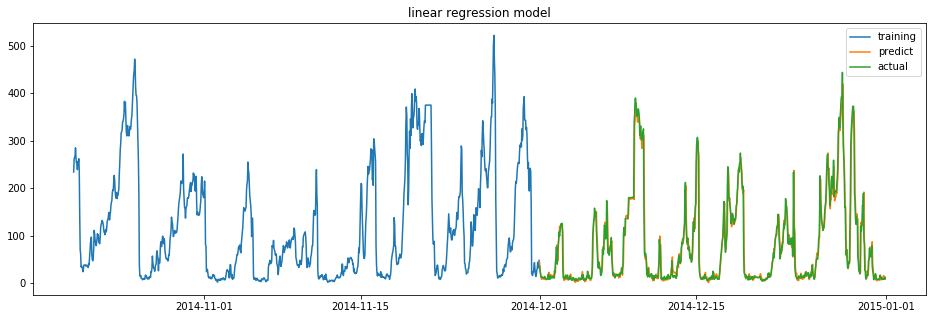

In [24]:
plot_train_test_pred(train_y, test_y, pdict_linear['lr']['predictions'], 'linear regression model')

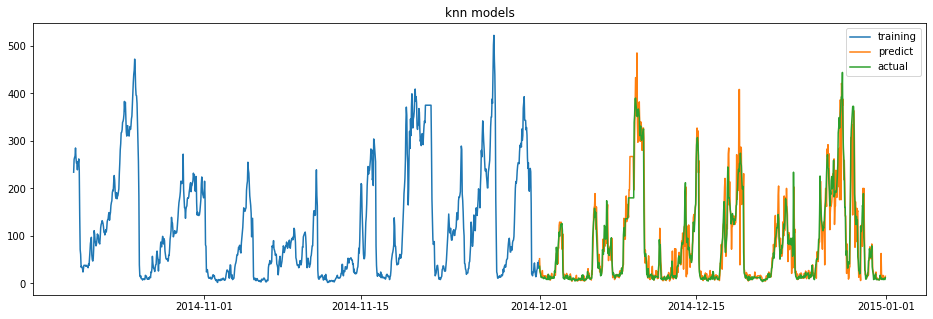

In [25]:
plot_train_test_pred(train_y, test_y, pdict_nonlinear['dt']['predictions'], 'knn models')

## Exercise

In [170]:
air_combined.shape

(43824, 74)

In [172]:
air_combined

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
2010-01-01 00:00:00,129.0,-21,-11.0,1021.0,1.79,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 01:00:00,129.0,-21,-12.0,1020.0,4.92,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 02:00:00,129.0,-21,-11.0,1019.0,6.71,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 03:00:00,129.0,-21,-14.0,1019.0,9.84,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 04:00:00,129.0,-20,-12.0,1018.0,12.97,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 05:00:00,129.0,-19,-10.0,1017.0,16.10,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 06:00:00,129.0,-19,-9.0,1017.0,19.23,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 07:00:00,129.0,-19,-9.0,1017.0,21.02,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 08:00:00,129.0,-19,-9.0,1017.0,24.15,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 09:00:00,129.0,-20,-8.0,1017.0,27.28,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [214]:
air_combined_shift = air_combined.shift(-1)
air_combined_shift.columns = [name+ "(t-1)" for name in air_combined_shift.columns]

air_combined_shift2 = pd.concat([air_combined, air_combined_shift], axis=1)[:-1]

air_combined_lag2 = air_combined_shift2.copy()

air_combined_lag2['label'] = air_combined_lag2['pm2.5'].shift(-50)
# air_combined_lag2 = air_combined_lag2.drop(['pm2.5'], axis=1)

# remove last value `
air_combined_lag2 = air_combined_lag2[:-50]


In [162]:
air_combined_lag2 = air_combined.copy()

air_combined_lag2['label'] = air_combined_lag2['pm2.5'].shift(-100)
# air_combined_lag2 = air_combined_lag2.drop(['pm2.5'], axis=1)

# remove last value `
air_combined_lag2 = air_combined_lag2[:-100]
air_combined_lag2[50:].head(10)

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,label
2010-01-03 02:00:00,65.0,-8,-7.0,1026.0,65.71,6,0,0,1,0,...,0,0,0,0,0,0,0,0,0,24.0
2010-01-03 03:00:00,55.0,-8,-7.0,1025.0,68.84,7,0,0,1,0,...,0,0,0,0,0,0,0,0,0,23.0
2010-01-03 04:00:00,65.0,-8,-7.0,1024.0,72.86,8,0,0,1,0,...,0,0,0,0,0,0,0,0,0,24.0
2010-01-03 05:00:00,83.0,-9,-8.0,1024.0,76.88,9,0,0,1,0,...,0,0,0,0,0,0,0,0,0,27.0
2010-01-03 06:00:00,91.0,-10,-8.0,1024.0,80.90,10,0,0,1,0,...,0,0,0,0,0,0,0,0,0,40.0
2010-01-03 07:00:00,86.0,-10,-9.0,1024.0,84.92,11,0,0,1,0,...,0,0,0,0,0,0,0,0,0,42.0
2010-01-03 08:00:00,82.0,-10,-9.0,1024.0,89.84,12,0,0,1,0,...,0,0,0,0,0,0,0,0,0,42.0
2010-01-03 09:00:00,86.0,-11,-9.0,1023.0,93.86,13,0,0,1,0,...,0,0,0,0,0,0,0,0,0,55.0
2010-01-03 10:00:00,78.0,-11,-9.0,1023.0,97.88,15,0,0,1,0,...,0,0,0,0,0,0,0,0,0,52.0
2010-01-03 11:00:00,98.0,-11,-9.0,1022.0,102.80,16,0,0,1,0,...,0,0,0,0,0,0,0,0,0,51.0


In [213]:
air_test

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,...,hour_15(t-1),hour_16(t-1),hour_17(t-1),hour_18(t-1),hour_19(t-1),hour_20(t-1),hour_21(t-1),hour_22(t-1),hour_23(t-1),label
2014-12-01 00:00:00,48.0,-25,-4.0,1030.0,190.45,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
2014-12-01 01:00:00,36.0,-24,-4.0,1029.0,200.28,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0
2014-12-01 02:00:00,25.0,-22,-4.0,1030.0,207.43,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
2014-12-01 03:00:00,21.0,-22,-5.0,1029.0,215.48,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0
2014-12-01 04:00:00,13.0,-21,-5.0,1030.0,220.40,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
2014-12-01 05:00:00,13.0,-22,-5.0,1031.0,230.23,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0
2014-12-01 06:00:00,12.0,-22,-5.0,1031.0,243.19,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
2014-12-01 07:00:00,13.0,-22,-5.0,1032.0,255.26,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
2014-12-01 08:00:00,12.0,-22,-5.0,1032.0,269.12,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0
2014-12-01 09:00:00,11.0,-22,-4.0,1033.0,278.95,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0


In [215]:
# seperate dataset into train and test
test_index = air_combined_lag2.index>='2014-12-01'

air_train = air_combined_lag2.loc[~test_index]
air_test = air_combined_lag2.loc[test_index]

# split into input and outputs
train_X, train_y = air_train.values[:, :-1], air_train.values[:, -1]
test_X, test_y = air_test.values[:, :-1], air_test.values[:, -1]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(43080, 148) (43080,) (693, 148) (693,)


In [216]:
test_y

array([111.,  26.,  11.,  13.,   9.,   9.,  13.,  17.,  16.,  11.,  11.,
        17.,   9.,   9.,  11.,   8.,  15.,  14.,   9.,   7.,   6.,   8.,
        11.,   9.,  11.,   9.,   8.,   5.,   6.,   9.,   6.,   7.,   7.,
         6.,   9.,  11.,  10.,  10.,   8.,   7.,  10.,   8.,  17.,   9.,
        18.,  10.,   6.,   6.,   9.,   8.,   7.,   8.,  14.,  12.,  25.,
        11.,  16.,  17.,  13.,   9.,   9.,   9.,  11.,  11.,  32.,  97.,
       115., 130., 138., 158., 140., 150., 149., 109.,  84.,  60.,  38.,
        32.,  44.,  31.,  31.,  30.,  16.,  17.,  19.,  33.,  71.,  66.,
        61.,  83., 122., 119.,  95.,  93., 102., 174., 137.,  80.,  63.,
        72.,  59.,  59.,  72.,  79.,  77.,  96.,  54.,  34.,  18.,  22.,
        21.,  15.,  13.,  11.,  17.,  18.,  16.,  17.,  18.,  16.,  15.,
        17.,  19.,  15.,  22.,  20.,  21.,  32.,  20.,  31.,  40., 102.,
       117., 100., 100., 136., 136., 136., 136., 136., 136., 145., 180.,
       180., 180., 180., 180., 180., 180., 180., 18

In [217]:
# from sklearn import preprocessing

# data normalization
scaler = preprocessing.StandardScaler().fit(train_X)
train_X_scaled = scaler.transform(train_X)
test_X_scaled = scaler.transform(test_X)

In [218]:
# # linear models
# print("\n Linear Models")
# pdict_linear = evaluate_models(get_linear_models(), train_X_scaled, train_y, test_X_scaled, test_y)

model = LinearRegression()
model_fit = model.fit(train_X_scaled, train_y)

In [219]:
# model_fit.coef_, model_fit.intercept_

In [220]:
pred = model_fit.predict(test_X_scaled)

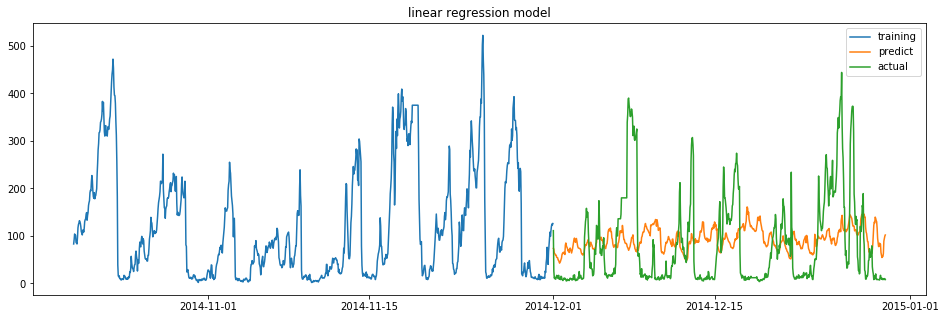

In [221]:
plot_train_test_pred(train_y, test_y, pred, 'linear regression model')

In [207]:
mean_absolute_error(pred, test_y)

69.61290607738034

In [208]:
mean_squared_error(pred, test_y)

7646.090919240476

In [209]:
pred

array([ 61.80253227,  46.25272758,  55.30839164,  37.96171195,
        34.90702445,  42.92753227,  32.63456352,  37.91386039,
        27.45585258,  24.19804008,  35.71757133,  23.3718682 ,
        24.67167289,  19.8562432 ,  17.5437432 ,   5.1038018 ,
        19.35673148,  15.88212211,  23.62040336,  18.43925102,
        29.91923148,  23.50834281,  42.48152585,  47.82596977,
        34.60233695,  73.90116508,  77.07987602,  75.03397758,
        63.41483695,  63.26542289,  58.30350883,  54.14042289,
        51.88944633,  60.09452445,  78.18827445,  89.54081352,
        97.39042289,  79.03983695,  78.1843682 ,  81.67020805,
        83.35868461,  91.18290336,  97.63602836,  87.32987602,
       111.50614555, 101.50443656,  86.28621335,  82.56522758,
        94.89823539,  90.7312432 ,  70.66386039,  56.70389945,
        53.57108695,  56.11893852,  44.12870414,  44.55448539,
        44.59647758,  48.9890557 ,  50.11014945,  40.41288383,
        39.68534477,  38.8249932 ,  26.1609307 ,  32.54

In [210]:
test_y

array([ 15.,  11.,  13.,  11.,  13.,  11.,  12.,  13.,  11.,  26.,  23.,
        43.,  52.,  76.,  66.,  40.,  67.,  81.,  96., 108.,  99., 111.,
       120., 125., 123., 126., 111.,  26.,  11.,  13.,   9.,   9.,  13.,
        17.,  16.,  11.,  11.,  17.,   9.,   9.,  11.,   8.,  15.,  14.,
         9.,   7.,   6.,   8.,  11.,   9.,  11.,   9.,   8.,   5.,   6.,
         9.,   6.,   7.,   7.,   6.,   9.,  11.,  10.,  10.,   8.,   7.,
        10.,   8.,  17.,   9.,  18.,  10.,   6.,   6.,   9.,   8.,   7.,
         8.,  14.,  12.,  25.,  11.,  16.,  17.,  13.,   9.,   9.,   9.,
        11.,  11.,  32.,  97., 115., 130., 138., 158., 140., 150., 149.,
       109.,  84.,  60.,  38.,  32.,  44.,  31.,  31.,  30.,  16.,  17.,
        19.,  33.,  71.,  66.,  61.,  83., 122., 119.,  95.,  93., 102.,
       174., 137.,  80.,  63.,  72.,  59.,  59.,  72.,  79.,  77.,  96.,
        54.,  34.,  18.,  22.,  21.,  15.,  13.,  11.,  17.,  18.,  16.,
        17.,  18.,  16.,  15.,  17.,  19.,  15.,  2